In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/100 [00:01<?, ?it/s]


torch.Size([6, 16, 315, 315])

In [3]:
# from tqdm import tqdm

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.batch_size,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
# # train_nshuffle_loader = DataLoader(
# #     train_nshuffle_dataset,
# #     batch_size=1,
# #     shuffle=True,
# #     drop_last=True,
# #     pin_memory=True,
# #     num_workers=CFG.num_workers,
# # )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )

# for data in tqdm(train_loader):
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

# normalized_tomogram.shape

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

In [5]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [7]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 320, 320])


In [8]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
# criterion = nn.CrossEntropyLoss(
#     #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
# )
criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [9]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [10]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [11]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([6, 16, 320, 320])

In [12]:
best_model = None
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            normalized_tomogram, segmentation_map = augment_data(
                normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()
            pred = model(preprocess_tensor(normalized_tomogram))
            loss = seg_loss(pred, segmentation_map)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            pred = model(preprocess_tensor(normalized_tomogram))
            loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in CFG.train_exp_names[:5]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=True
        )
        pred_df = inference2pos(
            pred_segmask=inferenced_array.argmax(0), exp_name=exp_name
        )
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])

        train_nshuffle_pred_tomogram[exp_name] = inferenced_array

        score_ = score(
            pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
        )
        train_mean_scores.append(score_)

    # print("train_mean_scores", np.mean(train_mean_scores))

    for exp_name in CFG.valid_exp_names:
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=True
        )
        pred_df = inference2pos(
            pred_segmask=inferenced_array.argmax(0), exp_name=exp_name
        )
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])

        valid_pred_tomogram[exp_name] = inferenced_array

        score_ = score(
            pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
        )
        valid_mean_scores.append(score_)

    # print("valid_mean_scores", np.mean(valid_mean_scores))

    if np.mean(valid_mean_scores) > best_score:
        best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{np.mean(valid_mean_scores):.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(np.mean(valid_mean_scores))

Epoch 1/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s, loss=0.9122]


train-epoch-loss:0.9369 valid-epoch-loss:0.9122 train-beta4-score:0.0027 valid-beta4-score:0.0060


Epoch 2/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s, loss=0.8750]


train-epoch-loss:0.8906 valid-epoch-loss:0.8750 train-beta4-score:0.0076 valid-beta4-score:0.0121


Epoch 3/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, loss=0.8447]


train-epoch-loss:0.8631 valid-epoch-loss:0.8447 train-beta4-score:0.0367 valid-beta4-score:0.0295


Epoch 4/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.8069]


train-epoch-loss:0.8446 valid-epoch-loss:0.8069 train-beta4-score:0.0670 valid-beta4-score:0.0617


Epoch 5/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, loss=0.8220]


train-epoch-loss:0.8270 valid-epoch-loss:0.8220 train-beta4-score:0.1095 valid-beta4-score:0.1001


Epoch 6/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, loss=0.8094]


train-epoch-loss:0.8123 valid-epoch-loss:0.8094 train-beta4-score:0.3349 valid-beta4-score:0.2905


Epoch 7/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s, loss=0.7108]


train-epoch-loss:0.8005 valid-epoch-loss:0.7108 train-beta4-score:0.2339 valid-beta4-score:0.2460


Epoch 8/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s, loss=0.7752]


train-epoch-loss:0.7928 valid-epoch-loss:0.7752 train-beta4-score:0.2652 valid-beta4-score:0.2511


Epoch 9/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s, loss=0.7574]


train-epoch-loss:0.7972 valid-epoch-loss:0.7574 train-beta4-score:0.2816 valid-beta4-score:0.2712


Epoch 10/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s, loss=0.8313]


train-epoch-loss:0.7860 valid-epoch-loss:0.8313 train-beta4-score:0.2622 valid-beta4-score:0.2560


Epoch 11/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s, loss=0.7205]


train-epoch-loss:0.7959 valid-epoch-loss:0.7205 train-beta4-score:0.2669 valid-beta4-score:0.2773


Epoch 12/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.7092]


train-epoch-loss:0.7946 valid-epoch-loss:0.7092 train-beta4-score:0.2869 valid-beta4-score:0.2995


Epoch 13/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6747]


train-epoch-loss:0.7887 valid-epoch-loss:0.6747 train-beta4-score:0.3423 valid-beta4-score:0.3173


Epoch 14/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.7183]


train-epoch-loss:0.7879 valid-epoch-loss:0.7183 train-beta4-score:0.3467 valid-beta4-score:0.3148


Epoch 15/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6622]


train-epoch-loss:0.7738 valid-epoch-loss:0.6622 train-beta4-score:0.3638 valid-beta4-score:0.3521


Epoch 16/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.7241]


train-epoch-loss:0.7703 valid-epoch-loss:0.7241 train-beta4-score:0.4588 valid-beta4-score:0.3557


Epoch 17/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.7747]


train-epoch-loss:0.7583 valid-epoch-loss:0.7747 train-beta4-score:0.3283 valid-beta4-score:0.2552


Epoch 18/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.6220]


train-epoch-loss:0.7628 valid-epoch-loss:0.6220 train-beta4-score:0.4492 valid-beta4-score:0.4096


Epoch 19/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6119]


train-epoch-loss:0.7552 valid-epoch-loss:0.6119 train-beta4-score:0.4307 valid-beta4-score:0.3713


Epoch 20/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6340]


train-epoch-loss:0.7506 valid-epoch-loss:0.6340 train-beta4-score:0.5607 valid-beta4-score:0.4493


Epoch 21/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6098]


train-epoch-loss:0.7520 valid-epoch-loss:0.6098 train-beta4-score:0.4622 valid-beta4-score:0.3733


Epoch 22/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.7853]


train-epoch-loss:0.7506 valid-epoch-loss:0.7853 train-beta4-score:0.4364 valid-beta4-score:0.3759


Epoch 23/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.6261]


train-epoch-loss:0.7429 valid-epoch-loss:0.6261 train-beta4-score:0.5130 valid-beta4-score:0.3947


Epoch 24/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.7253]


train-epoch-loss:0.7502 valid-epoch-loss:0.7253 train-beta4-score:0.3672 valid-beta4-score:0.3555


Epoch 25/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6314]


train-epoch-loss:0.7380 valid-epoch-loss:0.6314 train-beta4-score:0.4354 valid-beta4-score:0.3652


Epoch 26/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.6223]


train-epoch-loss:0.7467 valid-epoch-loss:0.6223 train-beta4-score:0.5522 valid-beta4-score:0.4386


Epoch 27/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5561]


train-epoch-loss:0.7438 valid-epoch-loss:0.5561 train-beta4-score:0.4277 valid-beta4-score:0.3841


Epoch 28/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7464]


train-epoch-loss:0.7381 valid-epoch-loss:0.7464 train-beta4-score:0.4095 valid-beta4-score:0.3373


Epoch 29/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6808]


train-epoch-loss:0.7358 valid-epoch-loss:0.6808 train-beta4-score:0.5119 valid-beta4-score:0.4410


Epoch 30/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6018]


train-epoch-loss:0.6989 valid-epoch-loss:0.6018 train-beta4-score:0.5781 valid-beta4-score:0.4681


Epoch 31/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6059]


train-epoch-loss:0.6958 valid-epoch-loss:0.6059 train-beta4-score:0.5669 valid-beta4-score:0.4429


Epoch 32/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.7500]


train-epoch-loss:0.6832 valid-epoch-loss:0.7500 train-beta4-score:0.5179 valid-beta4-score:0.4257


Epoch 33/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6333]


train-epoch-loss:0.6897 valid-epoch-loss:0.6333 train-beta4-score:0.3924 valid-beta4-score:0.3487


Epoch 34/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.5971]


train-epoch-loss:0.6684 valid-epoch-loss:0.5971 train-beta4-score:0.3984 valid-beta4-score:0.3731


Epoch 35/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s, loss=0.6524]


train-epoch-loss:0.6620 valid-epoch-loss:0.6524 train-beta4-score:0.6044 valid-beta4-score:0.4868


Epoch 36/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.6506]


train-epoch-loss:0.6438 valid-epoch-loss:0.6506 train-beta4-score:0.5908 valid-beta4-score:0.4436


Epoch 37/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5023]


train-epoch-loss:0.5901 valid-epoch-loss:0.5023 train-beta4-score:0.5127 valid-beta4-score:0.4067


Epoch 38/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5413]


train-epoch-loss:0.5672 valid-epoch-loss:0.5413 train-beta4-score:0.5497 valid-beta4-score:0.4484


Epoch 39/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.6596]


train-epoch-loss:0.5628 valid-epoch-loss:0.6596 train-beta4-score:0.5510 valid-beta4-score:0.4372


Epoch 40/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.6380]


train-epoch-loss:0.5605 valid-epoch-loss:0.6380 train-beta4-score:0.4798 valid-beta4-score:0.4177


Epoch 41/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.5281]


train-epoch-loss:0.5385 valid-epoch-loss:0.5281 train-beta4-score:0.5513 valid-beta4-score:0.4264


Epoch 42/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.5189]


train-epoch-loss:0.5355 valid-epoch-loss:0.5189 train-beta4-score:0.5119 valid-beta4-score:0.4157


Epoch 43/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s, loss=0.6698]


train-epoch-loss:0.5423 valid-epoch-loss:0.6698 train-beta4-score:0.5810 valid-beta4-score:0.4632


Epoch 44/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.3662]


train-epoch-loss:0.4535 valid-epoch-loss:0.3662 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 45/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s, loss=0.3127]


train-epoch-loss:0.4176 valid-epoch-loss:0.3127 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 46/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.7146]


train-epoch-loss:0.3965 valid-epoch-loss:0.7146 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 47/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5360]


train-epoch-loss:0.4016 valid-epoch-loss:0.5360 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 48/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.4734]


train-epoch-loss:0.4035 valid-epoch-loss:0.4734 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 49/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.3930]


train-epoch-loss:0.4104 valid-epoch-loss:0.3930 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 50/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.5583]


train-epoch-loss:0.4115 valid-epoch-loss:0.5583 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 51/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.3439]


train-epoch-loss:0.4179 valid-epoch-loss:0.3439 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 52/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.6744]


train-epoch-loss:0.4138 valid-epoch-loss:0.6744 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 53/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4779]


train-epoch-loss:0.4174 valid-epoch-loss:0.4779 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 54/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.7368]


train-epoch-loss:0.3856 valid-epoch-loss:0.7368 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 55/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5984]


train-epoch-loss:0.4020 valid-epoch-loss:0.5984 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 56/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4019]


train-epoch-loss:0.3876 valid-epoch-loss:0.4019 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 57/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.3840]


train-epoch-loss:0.4069 valid-epoch-loss:0.3840 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 58/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.4644]


train-epoch-loss:0.4196 valid-epoch-loss:0.4644 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 59/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.4689]


train-epoch-loss:0.3781 valid-epoch-loss:0.4689 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 60/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.5314]


train-epoch-loss:0.4212 valid-epoch-loss:0.5314 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 61/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.3036]


train-epoch-loss:0.3949 valid-epoch-loss:0.3036 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 62/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s, loss=0.3170]


train-epoch-loss:0.4269 valid-epoch-loss:0.3170 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 63/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7681]


train-epoch-loss:0.4051 valid-epoch-loss:0.7681 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 64/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.0848]


train-epoch-loss:0.4257 valid-epoch-loss:0.0848 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 65/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.3126]


train-epoch-loss:0.3938 valid-epoch-loss:0.3126 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 66/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4913]


train-epoch-loss:0.3898 valid-epoch-loss:0.4913 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 67/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.3438]


train-epoch-loss:0.4029 valid-epoch-loss:0.3438 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 68/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.6029]


train-epoch-loss:0.4069 valid-epoch-loss:0.6029 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 69/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.5582]


train-epoch-loss:0.3997 valid-epoch-loss:0.5582 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 70/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5626]


train-epoch-loss:0.4013 valid-epoch-loss:0.5626 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 71/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.2858]


train-epoch-loss:0.3889 valid-epoch-loss:0.2858 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 72/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.4690]


train-epoch-loss:0.4097 valid-epoch-loss:0.4690 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 73/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.3394]


train-epoch-loss:0.3850 valid-epoch-loss:0.3394 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 74/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.5002]


train-epoch-loss:0.3990 valid-epoch-loss:0.5002 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 75/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.6431]


train-epoch-loss:0.3983 valid-epoch-loss:0.6431 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 76/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.2947]


train-epoch-loss:0.3730 valid-epoch-loss:0.2947 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 77/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.3974]


train-epoch-loss:0.4007 valid-epoch-loss:0.3974 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 78/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6610]


train-epoch-loss:0.4021 valid-epoch-loss:0.6610 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 79/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.4555]


train-epoch-loss:0.4144 valid-epoch-loss:0.4555 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 80/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.7101]


train-epoch-loss:0.4067 valid-epoch-loss:0.7101 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 81/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6967]


train-epoch-loss:0.4161 valid-epoch-loss:0.6967 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 82/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.2947]


train-epoch-loss:0.3943 valid-epoch-loss:0.2947 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 83/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.3572]


train-epoch-loss:0.3929 valid-epoch-loss:0.3572 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 84/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.5271]


train-epoch-loss:0.4005 valid-epoch-loss:0.5271 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 85/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.5583]


train-epoch-loss:0.4028 valid-epoch-loss:0.5583 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 86/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.4957]


train-epoch-loss:0.3985 valid-epoch-loss:0.4957 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 87/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.7101]


train-epoch-loss:0.3847 valid-epoch-loss:0.7101 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 88/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.2902]


train-epoch-loss:0.3997 valid-epoch-loss:0.2902 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 89/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.1295]


train-epoch-loss:0.3998 valid-epoch-loss:0.1295 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 90/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.7369]


train-epoch-loss:0.3875 valid-epoch-loss:0.7369 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 91/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5001]


train-epoch-loss:0.4118 valid-epoch-loss:0.5001 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 92/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.7905]


train-epoch-loss:0.3833 valid-epoch-loss:0.7905 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 93/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.3840]


train-epoch-loss:0.4050 valid-epoch-loss:0.3840 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 94/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5761]


train-epoch-loss:0.3994 valid-epoch-loss:0.5761 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 95/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7816]


train-epoch-loss:0.4016 valid-epoch-loss:0.7816 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 96/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.6789]


train-epoch-loss:0.3864 valid-epoch-loss:0.6789 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 97/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.5225]


train-epoch-loss:0.4094 valid-epoch-loss:0.5225 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 98/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5850]


train-epoch-loss:0.4106 valid-epoch-loss:0.5850 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 99/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7146]


train-epoch-loss:0.3987 valid-epoch-loss:0.7146 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 100/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.3349]


train-epoch-loss:0.4085 valid-epoch-loss:0.3349 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 101/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5314]


train-epoch-loss:0.4062 valid-epoch-loss:0.5314 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 102/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.2679]


train-epoch-loss:0.4089 valid-epoch-loss:0.2679 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 103/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5270]


train-epoch-loss:0.4141 valid-epoch-loss:0.5270 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 104/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.7548]


train-epoch-loss:0.4088 valid-epoch-loss:0.7548 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 105/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.4645]


train-epoch-loss:0.3874 valid-epoch-loss:0.4645 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 106/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.7593]


train-epoch-loss:0.4034 valid-epoch-loss:0.7593 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 107/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5315]


train-epoch-loss:0.3933 valid-epoch-loss:0.5315 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 108/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.5092]


train-epoch-loss:0.3890 valid-epoch-loss:0.5092 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 109/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6521]


train-epoch-loss:0.3982 valid-epoch-loss:0.6521 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 110/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3617]


train-epoch-loss:0.3896 valid-epoch-loss:0.3617 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 111/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.1920]


train-epoch-loss:0.4219 valid-epoch-loss:0.1920 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 112/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.4912]


train-epoch-loss:0.3961 valid-epoch-loss:0.4912 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 113/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7726]


train-epoch-loss:0.4065 valid-epoch-loss:0.7726 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 114/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.7324]


train-epoch-loss:0.4032 valid-epoch-loss:0.7324 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 115/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s, loss=0.6074]


train-epoch-loss:0.3860 valid-epoch-loss:0.6074 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 116/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.6029]


train-epoch-loss:0.3988 valid-epoch-loss:0.6029 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 117/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.4019]


train-epoch-loss:0.4057 valid-epoch-loss:0.4019 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 118/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.6877]


train-epoch-loss:0.3819 valid-epoch-loss:0.6877 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 119/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4153]


train-epoch-loss:0.4145 valid-epoch-loss:0.4153 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 120/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3929]


train-epoch-loss:0.4071 valid-epoch-loss:0.3929 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 121/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3617]


train-epoch-loss:0.3941 valid-epoch-loss:0.3617 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 122/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.5761]


train-epoch-loss:0.4010 valid-epoch-loss:0.5761 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 123/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.7637]


train-epoch-loss:0.4078 valid-epoch-loss:0.7637 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 124/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6565]


train-epoch-loss:0.3933 valid-epoch-loss:0.6565 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 125/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5850]


train-epoch-loss:0.4062 valid-epoch-loss:0.5850 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 126/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.2813]


train-epoch-loss:0.3881 valid-epoch-loss:0.2813 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 127/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6298]


train-epoch-loss:0.3914 valid-epoch-loss:0.6298 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 128/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.6297]


train-epoch-loss:0.3956 valid-epoch-loss:0.6297 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 129/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s, loss=0.3974]


train-epoch-loss:0.3929 valid-epoch-loss:0.3974 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 130/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5894]


train-epoch-loss:0.3976 valid-epoch-loss:0.5894 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 131/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.6833]


train-epoch-loss:0.4049 valid-epoch-loss:0.6833 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 132/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.3171]


train-epoch-loss:0.4159 valid-epoch-loss:0.3171 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 133/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.4064]


train-epoch-loss:0.3975 valid-epoch-loss:0.4064 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 134/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.2902]


train-epoch-loss:0.4102 valid-epoch-loss:0.2902 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 135/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7548]


train-epoch-loss:0.4040 valid-epoch-loss:0.7548 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 136/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7414]


train-epoch-loss:0.4214 valid-epoch-loss:0.7414 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 137/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6342]


train-epoch-loss:0.4037 valid-epoch-loss:0.6342 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 138/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.3974]


train-epoch-loss:0.3930 valid-epoch-loss:0.3974 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 139/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.2545]


train-epoch-loss:0.3967 valid-epoch-loss:0.2545 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 140/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.2813]


train-epoch-loss:0.3856 valid-epoch-loss:0.2813 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 141/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6431]


train-epoch-loss:0.4079 valid-epoch-loss:0.6431 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 142/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.5627]


train-epoch-loss:0.4046 valid-epoch-loss:0.5627 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 143/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=0.7727]


train-epoch-loss:0.3737 valid-epoch-loss:0.7727 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 144/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.7593]


train-epoch-loss:0.4083 valid-epoch-loss:0.7593 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 145/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.5851]


train-epoch-loss:0.3906 valid-epoch-loss:0.5851 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 146/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4600]


train-epoch-loss:0.3818 valid-epoch-loss:0.4600 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 147/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4288]


train-epoch-loss:0.3934 valid-epoch-loss:0.4288 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 148/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.1474]


train-epoch-loss:0.3845 valid-epoch-loss:0.1474 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 149/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.2902]


train-epoch-loss:0.3967 valid-epoch-loss:0.2902 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 150/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6029]


train-epoch-loss:0.4059 valid-epoch-loss:0.6029 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 151/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.6163]


train-epoch-loss:0.4091 valid-epoch-loss:0.6163 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 152/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.5671]


train-epoch-loss:0.4191 valid-epoch-loss:0.5671 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 153/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5046]


train-epoch-loss:0.3860 valid-epoch-loss:0.5046 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 154/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.4108]


train-epoch-loss:0.3961 valid-epoch-loss:0.4108 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 155/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.2099]


train-epoch-loss:0.3999 valid-epoch-loss:0.2099 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 156/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.6521]


train-epoch-loss:0.4098 valid-epoch-loss:0.6521 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 157/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.1206]


train-epoch-loss:0.3976 valid-epoch-loss:0.1206 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 158/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.7860]


train-epoch-loss:0.3744 valid-epoch-loss:0.7860 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 159/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.7548]


train-epoch-loss:0.3920 valid-epoch-loss:0.7548 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 160/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.7324]


train-epoch-loss:0.3790 valid-epoch-loss:0.7324 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 161/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.5850]


train-epoch-loss:0.3925 valid-epoch-loss:0.5850 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 162/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.7191]


train-epoch-loss:0.4011 valid-epoch-loss:0.7191 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 163/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.2054]


train-epoch-loss:0.3890 valid-epoch-loss:0.2054 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 164/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.4153]


train-epoch-loss:0.3967 valid-epoch-loss:0.4153 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 165/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.2143]


train-epoch-loss:0.3986 valid-epoch-loss:0.2143 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 166/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s, loss=0.6297]


train-epoch-loss:0.3947 valid-epoch-loss:0.6297 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 167/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4823]


train-epoch-loss:0.3846 valid-epoch-loss:0.4823 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 168/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.7324]


train-epoch-loss:0.4004 valid-epoch-loss:0.7324 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 169/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.4778]


train-epoch-loss:0.3917 valid-epoch-loss:0.4778 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 170/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.4153]


train-epoch-loss:0.3798 valid-epoch-loss:0.4153 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 171/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.3572]


train-epoch-loss:0.4013 valid-epoch-loss:0.3572 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 172/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.3840]


train-epoch-loss:0.4108 valid-epoch-loss:0.3840 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 173/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.3126]


train-epoch-loss:0.4078 valid-epoch-loss:0.3126 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 174/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.5717]


train-epoch-loss:0.4063 valid-epoch-loss:0.5717 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 175/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.7414]


train-epoch-loss:0.4084 valid-epoch-loss:0.7414 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 176/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4689]


train-epoch-loss:0.3951 valid-epoch-loss:0.4689 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 177/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.3125]


train-epoch-loss:0.3975 valid-epoch-loss:0.3125 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 178/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.7860]


train-epoch-loss:0.3915 valid-epoch-loss:0.7860 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 179/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.3751]


train-epoch-loss:0.3871 valid-epoch-loss:0.3751 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 180/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6297]


train-epoch-loss:0.4068 valid-epoch-loss:0.6297 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 181/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.7681]


train-epoch-loss:0.4086 valid-epoch-loss:0.7681 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 182/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.6476]


train-epoch-loss:0.4122 valid-epoch-loss:0.6476 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 183/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5404]


train-epoch-loss:0.3942 valid-epoch-loss:0.5404 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 184/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5851]


train-epoch-loss:0.4073 valid-epoch-loss:0.5851 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 185/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.5806]


train-epoch-loss:0.3899 valid-epoch-loss:0.5806 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 186/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.7012]


train-epoch-loss:0.4133 valid-epoch-loss:0.7012 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 187/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s, loss=0.5717]


train-epoch-loss:0.3902 valid-epoch-loss:0.5717 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 188/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7280]


train-epoch-loss:0.4024 valid-epoch-loss:0.7280 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 189/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6967]


train-epoch-loss:0.3908 valid-epoch-loss:0.6967 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 190/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.2768]


train-epoch-loss:0.4180 valid-epoch-loss:0.2768 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 191/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.4422]


train-epoch-loss:0.3865 valid-epoch-loss:0.4422 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 192/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.1652]


train-epoch-loss:0.4054 valid-epoch-loss:0.1652 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 193/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.5315]


train-epoch-loss:0.4104 valid-epoch-loss:0.5315 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 194/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.5627]


train-epoch-loss:0.4204 valid-epoch-loss:0.5627 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 195/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.7861]


train-epoch-loss:0.3989 valid-epoch-loss:0.7861 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 196/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4867]


train-epoch-loss:0.3784 valid-epoch-loss:0.4867 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 197/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.5092]


train-epoch-loss:0.4044 valid-epoch-loss:0.5092 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 198/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s, loss=0.2545]


train-epoch-loss:0.3880 valid-epoch-loss:0.2545 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 199/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.5806]


train-epoch-loss:0.4029 valid-epoch-loss:0.5806 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 200/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.7235]


train-epoch-loss:0.3952 valid-epoch-loss:0.7235 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 201/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7816]


train-epoch-loss:0.4036 valid-epoch-loss:0.7816 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 202/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.2858]


train-epoch-loss:0.3954 valid-epoch-loss:0.2858 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 203/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.2902]


train-epoch-loss:0.3896 valid-epoch-loss:0.2902 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 204/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5225]


train-epoch-loss:0.3975 valid-epoch-loss:0.5225 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 205/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.7191]


train-epoch-loss:0.4103 valid-epoch-loss:0.7191 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 206/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.2947]


train-epoch-loss:0.4033 valid-epoch-loss:0.2947 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 207/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3929]


train-epoch-loss:0.3933 valid-epoch-loss:0.3929 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 208/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.7414]


train-epoch-loss:0.4068 valid-epoch-loss:0.7414 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 209/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.1741]


train-epoch-loss:0.3957 valid-epoch-loss:0.1741 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 210/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.47it/s, loss=0.7414]


train-epoch-loss:0.4011 valid-epoch-loss:0.7414 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 211/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.4287]


train-epoch-loss:0.4172 valid-epoch-loss:0.4287 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 212/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.4331]


train-epoch-loss:0.3934 valid-epoch-loss:0.4331 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 213/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7771]


train-epoch-loss:0.3852 valid-epoch-loss:0.7771 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 214/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, loss=0.2992]


train-epoch-loss:0.3960 valid-epoch-loss:0.2992 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 215/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.4198]


train-epoch-loss:0.3922 valid-epoch-loss:0.4198 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 216/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5671]


train-epoch-loss:0.4017 valid-epoch-loss:0.5671 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 217/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, loss=0.6699]


train-epoch-loss:0.4133 valid-epoch-loss:0.6699 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 218/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.2858]


train-epoch-loss:0.4164 valid-epoch-loss:0.2858 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 219/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.5315]


train-epoch-loss:0.4024 valid-epoch-loss:0.5315 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 220/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7727]


train-epoch-loss:0.3884 valid-epoch-loss:0.7727 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 221/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.6208]


train-epoch-loss:0.3871 valid-epoch-loss:0.6208 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 222/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3751]


train-epoch-loss:0.4036 valid-epoch-loss:0.3751 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 223/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.3662]


train-epoch-loss:0.4009 valid-epoch-loss:0.3662 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 224/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6119]


train-epoch-loss:0.3858 valid-epoch-loss:0.6119 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 225/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.2679]


train-epoch-loss:0.3967 valid-epoch-loss:0.2679 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 226/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3885]


train-epoch-loss:0.3987 valid-epoch-loss:0.3885 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 227/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=0.6520]


train-epoch-loss:0.3766 valid-epoch-loss:0.6520 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 228/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5850]


train-epoch-loss:0.4059 valid-epoch-loss:0.5850 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 229/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7101]


train-epoch-loss:0.4065 valid-epoch-loss:0.7101 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 230/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.4332]


train-epoch-loss:0.4085 valid-epoch-loss:0.4332 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 231/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.3260]


train-epoch-loss:0.4127 valid-epoch-loss:0.3260 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 232/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4466]


train-epoch-loss:0.3922 valid-epoch-loss:0.4466 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 233/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7681]


train-epoch-loss:0.3858 valid-epoch-loss:0.7681 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 234/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.4511]


train-epoch-loss:0.4058 valid-epoch-loss:0.4511 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 235/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5403]


train-epoch-loss:0.4013 valid-epoch-loss:0.5403 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 236/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3036]


train-epoch-loss:0.3926 valid-epoch-loss:0.3036 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 237/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6610]


train-epoch-loss:0.4052 valid-epoch-loss:0.6610 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 238/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.5716]


train-epoch-loss:0.4117 valid-epoch-loss:0.5716 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 239/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.6699]


train-epoch-loss:0.4178 valid-epoch-loss:0.6699 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 240/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.3349]


train-epoch-loss:0.4059 valid-epoch-loss:0.3349 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 241/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.5180]


train-epoch-loss:0.4088 valid-epoch-loss:0.5180 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 242/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.4377]


train-epoch-loss:0.3895 valid-epoch-loss:0.4377 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 243/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.3527]


train-epoch-loss:0.4071 valid-epoch-loss:0.3527 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 244/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.7815]


train-epoch-loss:0.3974 valid-epoch-loss:0.7815 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 245/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.4287]


train-epoch-loss:0.4108 valid-epoch-loss:0.4287 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 246/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7191]


train-epoch-loss:0.3841 valid-epoch-loss:0.7191 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 247/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.7324]


train-epoch-loss:0.4029 valid-epoch-loss:0.7324 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 248/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.3885]


train-epoch-loss:0.4156 valid-epoch-loss:0.3885 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 249/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s, loss=0.6609]


train-epoch-loss:0.3988 valid-epoch-loss:0.6609 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 250/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.5225]


train-epoch-loss:0.3777 valid-epoch-loss:0.5225 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 251/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.4867]


train-epoch-loss:0.3950 valid-epoch-loss:0.4867 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 252/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.1920]


train-epoch-loss:0.3903 valid-epoch-loss:0.1920 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 253/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s, loss=0.6476]


train-epoch-loss:0.4091 valid-epoch-loss:0.6476 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 254/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.4958]


train-epoch-loss:0.4058 valid-epoch-loss:0.4958 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 255/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.2501]


train-epoch-loss:0.3848 valid-epoch-loss:0.2501 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 256/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.3796]


train-epoch-loss:0.3931 valid-epoch-loss:0.3796 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 257/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.2902]


train-epoch-loss:0.3949 valid-epoch-loss:0.2902 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 258/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.7681]


train-epoch-loss:0.3869 valid-epoch-loss:0.7681 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 259/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.4555]


train-epoch-loss:0.3954 valid-epoch-loss:0.4555 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 260/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.5136]


train-epoch-loss:0.3892 valid-epoch-loss:0.5136 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 261/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.3170]


train-epoch-loss:0.4147 valid-epoch-loss:0.3170 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 262/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7504]


train-epoch-loss:0.4132 valid-epoch-loss:0.7504 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 263/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.5627]


train-epoch-loss:0.4006 valid-epoch-loss:0.5627 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 264/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.5225]


train-epoch-loss:0.3826 valid-epoch-loss:0.5225 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 265/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.6521]


train-epoch-loss:0.3725 valid-epoch-loss:0.6521 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 266/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.1786]


train-epoch-loss:0.4326 valid-epoch-loss:0.1786 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 267/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.7279]


train-epoch-loss:0.4032 valid-epoch-loss:0.7279 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 268/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s, loss=0.2947]


train-epoch-loss:0.3857 valid-epoch-loss:0.2947 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 269/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.4957]


train-epoch-loss:0.4115 valid-epoch-loss:0.4957 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 270/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=0.7637]


train-epoch-loss:0.4049 valid-epoch-loss:0.7637 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 271/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5047]


train-epoch-loss:0.3939 valid-epoch-loss:0.5047 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 272/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.7414]


train-epoch-loss:0.3825 valid-epoch-loss:0.7414 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 273/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.5136]


train-epoch-loss:0.4002 valid-epoch-loss:0.5136 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 274/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.6387]


train-epoch-loss:0.4011 valid-epoch-loss:0.6387 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 275/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.7637]


train-epoch-loss:0.3965 valid-epoch-loss:0.7637 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 276/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.3215]


train-epoch-loss:0.3864 valid-epoch-loss:0.3215 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 277/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, loss=0.5136]


train-epoch-loss:0.3940 valid-epoch-loss:0.5136 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 278/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=0.5002]


train-epoch-loss:0.4000 valid-epoch-loss:0.5002 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 279/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.5895]


train-epoch-loss:0.4050 valid-epoch-loss:0.5895 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 280/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s, loss=0.1875]


train-epoch-loss:0.3915 valid-epoch-loss:0.1875 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 281/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.5940]


train-epoch-loss:0.3976 valid-epoch-loss:0.5940 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 282/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.3840]


train-epoch-loss:0.4084 valid-epoch-loss:0.3840 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 283/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.2500]


train-epoch-loss:0.3957 valid-epoch-loss:0.2500 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 284/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s, loss=0.3706]


train-epoch-loss:0.3866 valid-epoch-loss:0.3706 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 285/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.1652]


train-epoch-loss:0.4048 valid-epoch-loss:0.1652 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 286/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s, loss=0.3885]


train-epoch-loss:0.4067 valid-epoch-loss:0.3885 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 287/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=0.5181]


train-epoch-loss:0.3999 valid-epoch-loss:0.5181 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 288/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=0.6788]


train-epoch-loss:0.4100 valid-epoch-loss:0.6788 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 289/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s, loss=0.2411]


train-epoch-loss:0.4060 valid-epoch-loss:0.2411 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 290/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=0.2724]


train-epoch-loss:0.3990 valid-epoch-loss:0.2724 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 291/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s, loss=0.4778]


train-epoch-loss:0.4043 valid-epoch-loss:0.4778 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 292/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s, loss=0.4688]


train-epoch-loss:0.4016 valid-epoch-loss:0.4688 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 293/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s, loss=0.3796]


train-epoch-loss:0.3864 valid-epoch-loss:0.3796 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 294/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.39it/s, loss=0.3707]


train-epoch-loss:0.4023 valid-epoch-loss:0.3707 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 295/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s, loss=0.2858]


train-epoch-loss:0.4004 valid-epoch-loss:0.2858 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 296/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=0.0670]


train-epoch-loss:0.4107 valid-epoch-loss:0.0670 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 297/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.4778]


train-epoch-loss:0.3959 valid-epoch-loss:0.4778 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 298/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=0.5939]


train-epoch-loss:0.4067 valid-epoch-loss:0.5939 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 299/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.5984]


train-epoch-loss:0.4024 valid-epoch-loss:0.5984 train-beta4-score:0.0000 valid-beta4-score:0.0000


Epoch 300/300 [Validation]: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s, loss=0.4376]


train-epoch-loss:0.3989 valid-epoch-loss:0.4376 train-beta4-score:0.0000 valid-beta4-score:0.0000


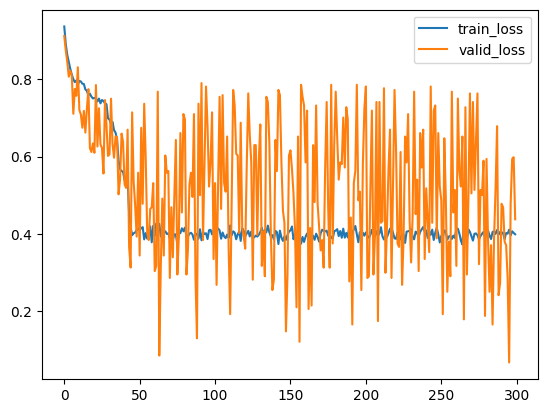

In [13]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

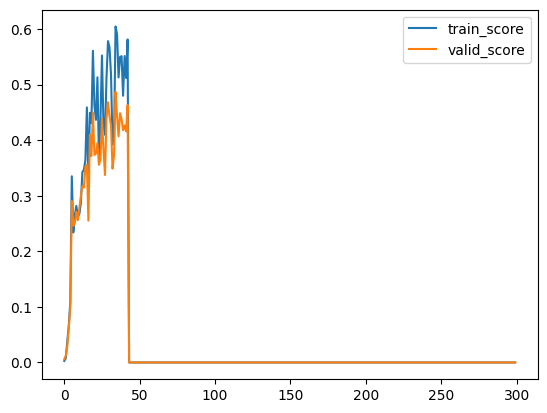

In [14]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [15]:
random.random()

0.5347047188991721